Data: Movies Review Data
    
Tasks:
- Data preparation
- Exploratory Data Analysis
    - What is the distribution of age and gender of the reviewers? 
    - How are the movies rated?
    - What time of the day do people usually review a movie?
    - How did the entertainment industry change over the years?
- Classification
    - Can we classify the gender of the reviewer from the ratings and movies watched?


In [1]:
import findspark
findspark.init()
import pyspark
import re

import numpy as np
import scipy.sparse as sps
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 
from pyspark.mllib.classification import *
import pandas as pd

from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel

In [4]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '20')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4214 rus217


In [5]:
sc = pyspark.SparkContext(appName="Project3", master='',conf = config )

In [6]:
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [7]:
ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()

In [9]:
age_group = {}
age_group[1]='Under 18'
age_group[18]='18-24'
age_group[25]='25-34'
age_group[35]='35-44'
age_group[45]='45-49'
age_group[50]='50-55'
age_group[56]='56+'

In [10]:
age_group

{1: 'Under 18',
 18: '18-24',
 25: '25-34',
 35: '35-44',
 45: '45-49',
 50: '50-55',
 56: '56+'}

In [11]:
with open('Book1.csv','r') as f:
    occupation_data = f.readlines()

print occupation_data,'\n'
occupation = []
for i in occupation_data:
    occupation.append(i.strip('\r\n'))

del occupation[0]
codes_occ ={}
for i in occupation:
    i = i.split(',')
    st = i[1].strip(' ')
    codes_occ[i[0]]=st
    
codes_occ

['Code,Occupation\r\n', '0,   other  or not specified\r\n', '1,   academic/educator \r\n', '2,   artist \r\n', '3,   clerical/admin \r\n', '4,   college/grad student \r\n', '5,   customer service \r\n', '6,   doctor/health care \r\n', '7,   executive/managerial \r\n', '8,   farmer \r\n', '9,   homemaker \r\n', '10,   K-12 student \r\n', '11,   lawyer \r\n', '12,   programmer \r\n', '13,   retired \r\n', '14,   sales/marketing \r\n', '15,   scientist \r\n', '16,   self-employed \r\n', '17,   technician/engineer \r\n', '18,   tradesman/craftsman \r\n', '19,   unemployed \r\n', '20,   writer \r\n'] 



{'0': 'other  or not specified',
 '1': 'academic/educator',
 '10': 'K-12 student',
 '11': 'lawyer',
 '12': 'programmer',
 '13': 'retired',
 '14': 'sales/marketing',
 '15': 'scientist',
 '16': 'self-employed',
 '17': 'technician/engineer',
 '18': 'tradesman/craftsman',
 '19': 'unemployed',
 '2': 'artist',
 '20': 'writer',
 '3': 'clerical/admin',
 '4': 'college/grad student',
 '5': 'customer service',
 '6': 'doctor/health care',
 '7': 'executive/managerial',
 '8': 'farmer',
 '9': 'homemaker'}

In [12]:
movies=sc.textFile('movies.dat')
movies.take(10)

[u"1::Toy Story (1995)::Animation|Children's|Comedy",
 u"2::Jumanji (1995)::Adventure|Children's|Fantasy",
 u'3::Grumpier Old Men (1995)::Comedy|Romance',
 u'4::Waiting to Exhale (1995)::Comedy|Drama',
 u'5::Father of the Bride Part II (1995)::Comedy',
 u'6::Heat (1995)::Action|Crime|Thriller',
 u'7::Sabrina (1995)::Comedy|Romance',
 u"8::Tom and Huck (1995)::Adventure|Children's",
 u'9::Sudden Death (1995)::Action',
 u'10::GoldenEye (1995)::Action|Adventure|Thriller']

In [13]:
ratings = sc.textFile('ratings.dat')
ratings.take(10)

[u'1::1193::5::978300760',
 u'1::661::3::978302109',
 u'1::914::3::978301968',
 u'1::3408::4::978300275',
 u'1::2355::5::978824291',
 u'1::1197::3::978302268',
 u'1::1287::5::978302039',
 u'1::2804::5::978300719',
 u'1::594::4::978302268',
 u'1::919::4::978301368']

In [14]:
users= sc.textFile('users.dat')
users.take(10)

[u'1::F::1::10::48067',
 u'2::M::56::16::70072',
 u'3::M::25::15::55117',
 u'4::M::45::7::02460',
 u'5::M::25::20::55455',
 u'6::F::50::9::55117',
 u'7::M::35::1::06810',
 u'8::M::25::12::11413',
 u'9::M::25::17::61614',
 u'10::F::35::1::95370']

## Data Cleaning

In [15]:
def movie_clean(x):
    d=x.split('::')
    movieid = d[0]
    title = d[1][:-6]
    year1 = d[1][-5:-1]
    genre = d[2]
    return (int(movieid),','.join(title).replace(',','').encode("utf-8"),int(''.join(str(e) for e in year1)),str(genre))

In the above cleaning: 

1) Had to encode ("utf-8") for special characters

2)First separated the year from movie name using space, but there are few movies 
  where there is no space between year released and name. Finally resolved this   by observing that the length of year is always 6. (xxxx), so did indexing.
  

In [16]:
movie_clean(u"1::Toy Story (1995)::Animation|Children's|Comedy")

(1, 'Toy Story ', 1995, "Animation|Children's|Comedy")

In [17]:
movie = ['movieid','title','year','genre']
movie_1 = movies.map(movie_clean)
print movie_1.take(3),'\n'
movie_1.toDF(movie).show(3)

[(1, 'Toy Story ', 1995, "Animation|Children's|Comedy"), (2, 'Jumanji ', 1995, "Adventure|Children's|Fantasy"), (3, 'Grumpier Old Men ', 1995, 'Comedy|Romance')] 

+-------+-----------------+----+--------------------+
|movieid|            title|year|               genre|
+-------+-----------------+----+--------------------+
|      1|       Toy Story |1995|Animation|Childre...|
|      2|         Jumanji |1995|Adventure|Childre...|
|      3|Grumpier Old Men |1995|      Comedy|Romance|
+-------+-----------------+----+--------------------+
only showing top 3 rows



In [18]:
import datetime
fmt = "%Y-%m-%d %H"

The timestamp is from epoch. So, I converted that using datetime. I have just taken the hour of the day for further analysis.

In [19]:
def rating_clean(x):
    d=x.split('::')
    userid = d[0]
    movieid = d[1]
    rating = d[2]
    t = datetime.datetime.fromtimestamp(float(d[3]))
    timestamp = t.strftime(fmt)
    day = timestamp.split(' ')[0]
    time = timestamp.split(' ')[1]
    return (int(userid),int(movieid),float(rating),day,time)

In [20]:
rating = ['userid','movieid','rating','day','time']
rating_1 = ratings.map(rating_clean)
print rating_1.take(2),'\n'
rating_1.toDF(rating).show(3)

[(1, 1193, 5.0, '2000-12-31', '17'), (1, 661, 3.0, '2000-12-31', '17')] 

+------+-------+------+----------+----+
|userid|movieid|rating|       day|time|
+------+-------+------+----------+----+
|     1|   1193|   5.0|2000-12-31|  17|
|     1|    661|   3.0|2000-12-31|  17|
|     1|    914|   3.0|2000-12-31|  17|
+------+-------+------+----------+----+
only showing top 3 rows



In [21]:
def user_clean(x):
    d=x.split('::')
    userid = d[0]
    gender = d[1]
    age = d[2]
    occupation = d[3]
    zipcode = d[4]
    return (userid,gender,age,occupation,zipcode)

In [22]:
user =['userid','gender','age','occupation','zipcode']
user_1 = users.map(user_clean)
print user_1.take(2),'\n'
user_1.toDF(user).show(3)

[(u'1', u'F', u'1', u'10', u'48067'), (u'2', u'M', u'56', u'16', u'70072')] 

+------+------+---+----------+-------+
|userid|gender|age|occupation|zipcode|
+------+------+---+----------+-------+
|     1|     F|  1|        10|  48067|
|     2|     M| 56|        16|  70072|
|     3|     M| 25|        15|  55117|
+------+------+---+----------+-------+
only showing top 3 rows



In [23]:
movie_df = movie_1.toDF(movie)
rating_df=rating_1.toDF(rating)
user_df = user_1.toDF(user)

## Exploratory Data Analysis

### Distributions

In [24]:
#Analyzing user profiles
user_df.createOrReplaceTempView('user')
rating_df.createOrReplaceTempView('rating')
movie_df.createOrReplaceTempView('movie')

In [25]:
ss.sql(' SELECT gender,COUNT(userid) FROM user GROUP BY gender').show()
ss.sql(' SELECT age,COUNT(userid) FROM user GROUP BY age').show()

+------+-------------+
|gender|count(userid)|
+------+-------------+
|     F|         1709|
|     M|         4331|
+------+-------------+

+---+-------------+
|age|count(userid)|
+---+-------------+
| 35|         1193|
| 18|         1103|
| 25|         2096|
|  1|          222|
| 56|          380|
| 50|          496|
| 45|          550|
+---+-------------+



In [26]:
ss.sql('SELECT rating,COUNT(movieid) FROM rating GROUP BY rating ORDER BY rating').show()

+------+--------------+
|rating|count(movieid)|
+------+--------------+
|   1.0|         56174|
|   2.0|        107557|
|   3.0|        261197|
|   4.0|        348971|
|   5.0|        226310|
+------+--------------+



In [27]:
time_dist = rating_1.map(lambda x:(int(x[4]),1)).reduceByKey(lambda a,b:a+b).collect()

In [28]:
time = []
count = []
for i in sorted(time_dist):
    time.append(i[0])
    count.append(i[1])

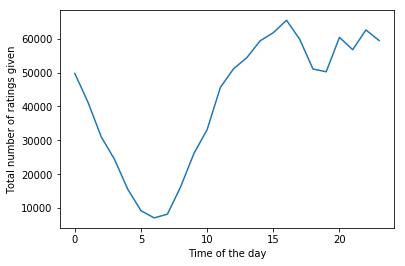

Lowest ratings during morning hours and highest during late afternoon

Another such analysis could be which month of year, maybe during vactions       there colud be more number of ratings


In [29]:
plt.ylabel('Total number of ratings given')
plt.xlabel('Time of the day') 
plt.plot(time,count)
plt.show()


People usually review the movies after late afternoon.
<br>Another such analysis could be which month of year, maybe during vacations there could be more number of ratings.

In [30]:
#Top Rated Movies (Movies voted maximum time)
ss.sql('SELECT movieid,COUNT(rating) FROM rating GROUP BY movieid ORDER BY COUNT(rating) DESC').show()

+-------+-------------+
|movieid|count(rating)|
+-------+-------------+
|   2858|         3428|
|    260|         2991|
|   1196|         2990|
|   1210|         2883|
|    480|         2672|
|   2028|         2653|
|    589|         2649|
|   2571|         2590|
|   1270|         2583|
|    593|         2578|
|   1580|         2538|
|   1198|         2514|
|    608|         2513|
|   2762|         2459|
|    110|         2443|
|   2396|         2369|
|   1197|         2318|
|    527|         2304|
|   1617|         2288|
|   1265|         2278|
+-------+-------------+
only showing top 20 rows



In [31]:
#Graph of yearly releases
ss.sql('SELECT year,COUNT(year) FROM movie GROUP BY year ORDER BY COUNT(year) DESC').show()

+----+-----------+
|year|count(year)|
+----+-----------+
|1996|        345|
|1995|        342|
|1998|        337|
|1997|        315|
|1999|        283|
|1994|        257|
|1993|        165|
|2000|        156|
|1986|        104|
|1992|        102|
|1990|         77|
|1987|         71|
|1988|         69|
|1985|         65|
|1989|         60|
|1984|         60|
|1991|         60|
|1982|         50|
|1981|         43|
|1980|         41|
+----+-----------+
only showing top 20 rows



In [32]:
year = movie_1.map(lambda x:(x[2],1)).reduceByKey(lambda a,b:a+b).collect()

In [33]:
year2 = []
count2 = []
for i in sorted(year):
    year2.append(i[0])
    count2.append(i[1])

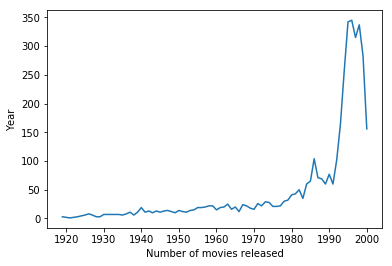

In [34]:
plt.ylabel('Year')
plt.xlabel('Number of movies released') 
plt.plot(year2,count2)
plt.show()

## Classification

In [50]:
#Classification Data Split
#1)Total number of movies seen in each genre
#2)Logistic

In [51]:
print rating_1.take(10),'\n'
print dense_movie.take(10)

[(1, 1193, 5.0, '2000-12-31', '17'), (1, 661, 3.0, '2000-12-31', '17'), (1, 914, 3.0, '2000-12-31', '17'), (1, 3408, 4.0, '2000-12-31', '17'), (1, 2355, 5.0, '2001-01-06', '18'), (1, 1197, 3.0, '2000-12-31', '17'), (1, 1287, 5.0, '2000-12-31', '17'), (1, 2804, 5.0, '2000-12-31', '17'), (1, 594, 4.0, '2000-12-31', '17'), (1, 919, 4.0, '2000-12-31', '17')] 

[[1, array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])], [2, array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])], [3, array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0.])], [4, array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])], [5, array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])], [6, array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0.])], [7, array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
   

### Movie Genre Dictionary

In [60]:

movie_gen_dict ={}
for i in dense_movie.collect():
    movie_gen_dict[i[0]]=i[1]
        

In [61]:
movie_gen_dict

{1: array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 2: array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.]),
 4: array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 5: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 6: array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.]),
 7: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.]),
 8: array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 9: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 10: array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.]),
 11: array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0

In [62]:
classi = rating_1.map(lambda x: (x[0],x[1])).groupByKey().mapValues(list)

In [63]:
classi.sortByKey().take(4)

[(1,
  [1193,
   661,
   914,
   3408,
   2355,
   1197,
   1287,
   2804,
   594,
   919,
   595,
   938,
   2398,
   2918,
   1035,
   2791,
   2687,
   2018,
   3105,
   2797,
   2321,
   720,
   1270,
   527,
   2340,
   48,
   1097,
   1721,
   1545,
   745,
   2294,
   3186,
   1566,
   588,
   1907,
   783,
   1836,
   1022,
   2762,
   150,
   1,
   1961,
   1962,
   2692,
   260,
   1028,
   1029,
   1207,
   2028,
   531,
   3114,
   608,
   1246]),
 (2,
  [1357,
   3068,
   1537,
   647,
   2194,
   648,
   2268,
   2628,
   1103,
   2916,
   3468,
   1210,
   1792,
   1687,
   1213,
   3578,
   2881,
   3030,
   1217,
   3105,
   434,
   2126,
   3107,
   3108,
   3035,
   1253,
   1610,
   292,
   2236,
   3071,
   902,
   368,
   1259,
   3147,
   1544,
   1293,
   1188,
   3255,
   3256,
   3257,
   110,
   2278,
   2490,
   1834,
   3471,
   589,
   1690,
   3654,
   2852,
   1945,
   982,
   1873,
   2858,
   1225,
   2028,
   515,
   442,
   2312,
   265,
   1408,
   

In [64]:
def total_movies_by_genre(x):
    array_gen = []
    for i in x[1]:
        array_gen.append(movie_gen_dict[i])
    return (x[0],sum(array_gen))

total_by_gen = classi.map(total_movies_by_genre)

In [65]:
total_by_gen.take(2)

[(2, array([56., 19.,  0.,  0., 25., 12.,  0., 79.,  1.,  1.,  2.,  0.,  3.,
         24., 17., 31., 15.,  3.])),
 (4, array([19.,  6.,  0.,  1.,  0.,  1.,  0.,  6.,  2.,  0.,  3.,  0.,  0.,
          2.,  9.,  4.,  3.,  2.]))]

In [66]:
user_1.take(2)
user_profile = user_1.collect()

In [67]:
user_profile[:2]

[(u'1', u'F', u'1', u'10', u'48067'), (u'2', u'M', u'56', u'16', u'70072')]

In [68]:
def sparse1(x):
    size = len(x[1])
    location = []
    value = []
    for i in range(size):
        if x[1][i]!=0:
            location.append(i)
            value.append(x[1][i])
    features = SparseVector(size,location,value)
    return (x[0],features)

In [69]:
total_by_gen = total_by_gen.map(sparse1)

In [71]:
def gender_imputation(x):
    i = x[0]
    for a in user_profile:
        if int(float(a[0]))== i:
            if str(a[1]) == 'M':
                g = 1
            else:
                g = 0
            return (i,g,x[1])


In [72]:
classi_input = total_by_gen.map(gender_imputation)

In [73]:
classi_input.take(3)

[(2,
  1,
  SparseVector(18, {0: 56.0, 1: 19.0, 4: 25.0, 5: 12.0, 7: 79.0, 8: 1.0, 9: 1.0, 10: 2.0, 12: 3.0, 13: 24.0, 14: 17.0, 15: 31.0, 16: 15.0, 17: 3.0})),
 (4,
  1,
  SparseVector(18, {0: 19.0, 1: 6.0, 3: 1.0, 5: 1.0, 7: 6.0, 8: 2.0, 10: 3.0, 13: 2.0, 14: 9.0, 15: 4.0, 16: 3.0, 17: 2.0})),
 (6,
  0,
  SparseVector(18, {0: 11.0, 1: 8.0, 2: 9.0, 3: 16.0, 4: 32.0, 5: 2.0, 7: 22.0, 8: 2.0, 11: 19.0, 13: 34.0, 14: 2.0, 15: 3.0, 16: 5.0, 17: 8.0}))]

#### SPLIT DATA FOR CLASSIFICATION

In [74]:
train_class,test_class = classi_input.randomSplit([0.6,0.4],seed =12345)

In [75]:
train_class.take(2)

[(2,
  1,
  SparseVector(18, {0: 56.0, 1: 19.0, 4: 25.0, 5: 12.0, 7: 79.0, 8: 1.0, 9: 1.0, 10: 2.0, 12: 3.0, 13: 24.0, 14: 17.0, 15: 31.0, 16: 15.0, 17: 3.0})),
 (4,
  1,
  SparseVector(18, {0: 19.0, 1: 6.0, 3: 1.0, 5: 1.0, 7: 6.0, 8: 2.0, 10: 3.0, 13: 2.0, 14: 9.0, 15: 4.0, 16: 3.0, 17: 2.0}))]

In [76]:
test_class.take(2)

[(10,
  0,
  SparseVector(18, {0: 81.0, 1: 70.0, 2: 33.0, 3: 64.0, 4: 183.0, 5: 15.0, 6: 2.0, 7: 116.0, 8: 38.0, 9: 4.0, 10: 19.0, 11: 37.0, 12: 8.0, 13: 67.0, 14: 71.0, 15: 27.0, 16: 24.0, 17: 8.0})),
 (14,
  1,
  SparseVector(18, {0: 4.0, 4: 8.0, 5: 3.0, 7: 13.0, 10: 4.0, 12: 1.0, 13: 6.0, 14: 2.0, 15: 4.0, 16: 1.0}))]

In [77]:
test_class_drop = test_class.map(lambda x:(x[1],x[2]))
test_class_drop.take(3)

[(0,
  SparseVector(18, {0: 81.0, 1: 70.0, 2: 33.0, 3: 64.0, 4: 183.0, 5: 15.0, 6: 2.0, 7: 116.0, 8: 38.0, 9: 4.0, 10: 19.0, 11: 37.0, 12: 8.0, 13: 67.0, 14: 71.0, 15: 27.0, 16: 24.0, 17: 8.0})),
 (1,
  SparseVector(18, {0: 4.0, 4: 8.0, 5: 3.0, 7: 13.0, 10: 4.0, 12: 1.0, 13: 6.0, 14: 2.0, 15: 4.0, 16: 1.0})),
 (1,
  SparseVector(18, {0: 105.0, 1: 51.0, 2: 11.0, 3: 19.0, 4: 140.0, 5: 24.0, 6: 1.0, 7: 55.0, 8: 13.0, 9: 2.0, 10: 31.0, 11: 6.0, 12: 11.0, 13: 30.0, 14: 58.0, 15: 88.0, 16: 14.0, 17: 4.0}))]

In [78]:
train_class_data = train_class.map(lambda x: LabeledPoint(x[1],x[2]))

#### Classification model and predictions

In [79]:
model = LogisticRegressionWithLBFGS.train(train_class_data)

In [487]:
def PredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r[1]))
    return predictions.zip(test_data.map(lambda r: r[0]))

In [488]:
predictions_and_labels = PredictionsLabels(model, test_class_drop)
print predictions_and_labels.take(10)

[(1, 0), (0, 1), (1, 1), (1, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


In [489]:
def accuracy((x,y)):
    true_pred =0
    if x==y:
        true_pred = 1
    else:
        pass
    return true_pred   

In [491]:
total = test_class_drop.count()
true = predictions_and_labels.map(accuracy).reduce(lambda x,y:x+y)

print "Correctly identified: ",true
print "Incorrect identification: ",total-true

print "Accuracy is {} %".format(round(true*100.0/total,2))

Correctly identified:  1874
Incorrect identification:  513
Accuracy is 78.51 %


In [130]:
sc.stop()